# Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model import CNN_Segmentation
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
from utils import color_map
from utils import ImageSegmentationTrainingDataset,show_images_batch

/home/hellottie/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/hellottie/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Load

In [2]:
def load_model():
  model_instance = CNN_Segmentation()
  model_instance.load_state_dict(torch.load('segmentation_model.pth', map_location='cpu'))
  model_instance.eval()  # set model to evaluation mode
  return model_instance

transform = transforms.Compose([
    transforms.ToTensor(),
])

model = load_model()
dataset = ImageSegmentationTrainingDataset(root_dir='train', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Test

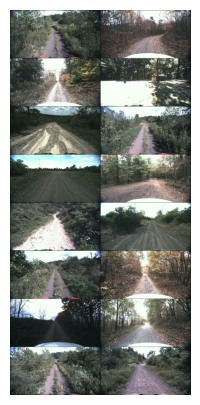

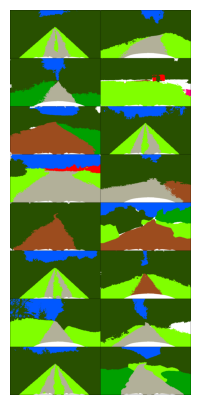

torch.Size([16, 3, 544, 1024])
torch.Size([16, 3, 544, 1024])
torch.Size([16, 9, 544, 1024])


In [3]:
# Show comparisons for first batch in batch in batches
for images,labels,onehotencoding in dataloader:
    show_images_batch(images)
    show_images_batch(labels)
    print(images.shape)
    print(labels.shape)
    print(onehotencoding.shape)
    break

## After training

In [4]:
def convert_prediction_to_rgb(pred, color_map):
    class_map = pred.argmax(dim=0).cpu().numpy()  # (H, W)
    inverse_color_map = {v: k for k, v in color_map.items()}
    h, w = class_map.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in inverse_color_map.items():
        rgb[class_map == class_idx] = color
    return rgb

In [5]:
def visualize_sample_prediction(model, rgb_path, label_path, color_map, device):
    # Load images
    rgb_image = Image.open(rgb_path).convert("RGB")
    label_image = Image.open(label_path).convert("RGB")

    # Transform input image to tensor
    transform = T.Compose([
        T.ToTensor(),  # scales to [0, 1]
    ])
    image_tensor = transform(rgb_image).unsqueeze(0).to(device)  # (1, 3, H, W)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # (1, 9, H, W)
        output = output.squeeze(0).softmax(dim=0)  # (9, H, W)

    # Convert to RGB for visualization
    pred_rgb = convert_prediction_to_rgb(output, color_map)

    # Plot all
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(rgb_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(label_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Model Prediction")
    plt.imshow(pred_rgb)
    plt.axis("off")

    plt.show()


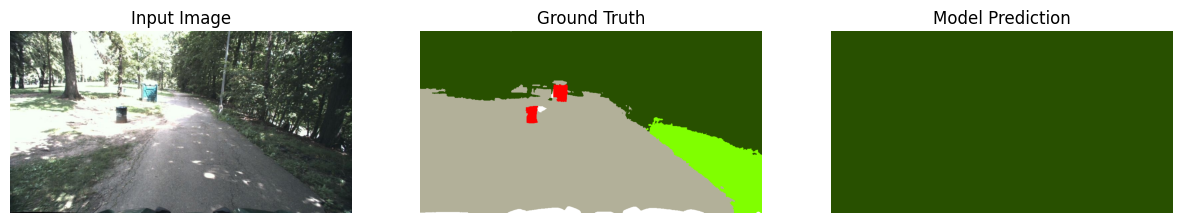

In [6]:
test_dir = "./train"
sample_dir = os.path.join(test_dir, "0001")  # change to any valid sample
rgb_path = os.path.join(sample_dir, "rgb.jpg")
label_path = os.path.join(sample_dir, "labels.png")

visualize_sample_prediction(model, rgb_path, label_path, color_map, device)

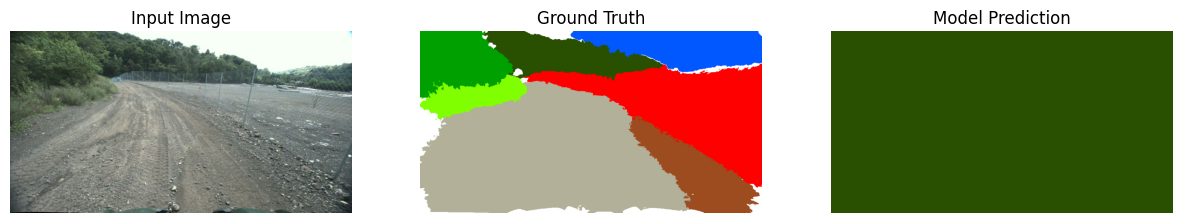

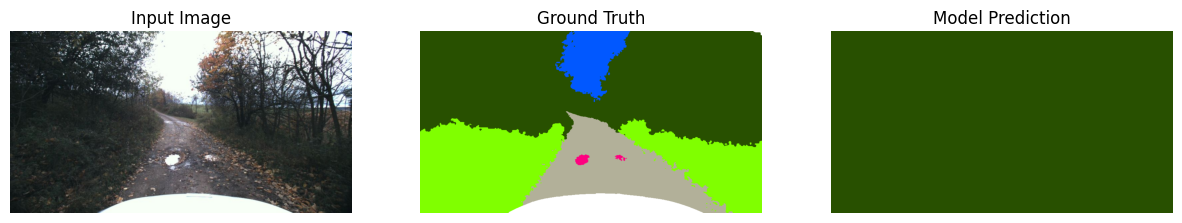

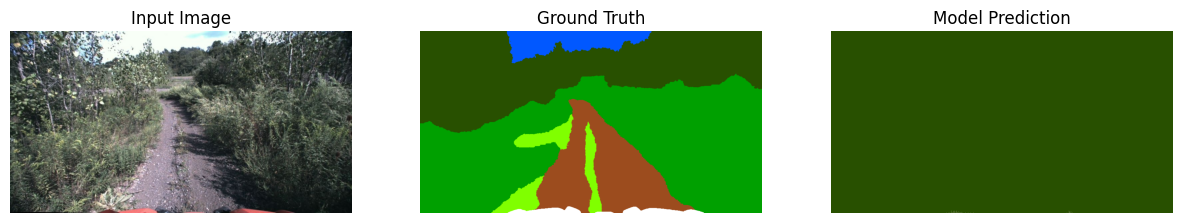

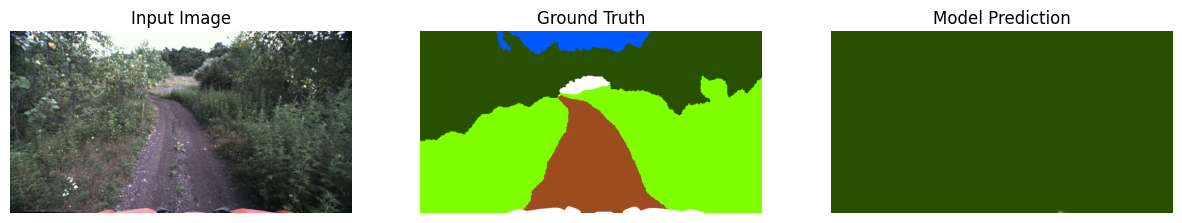

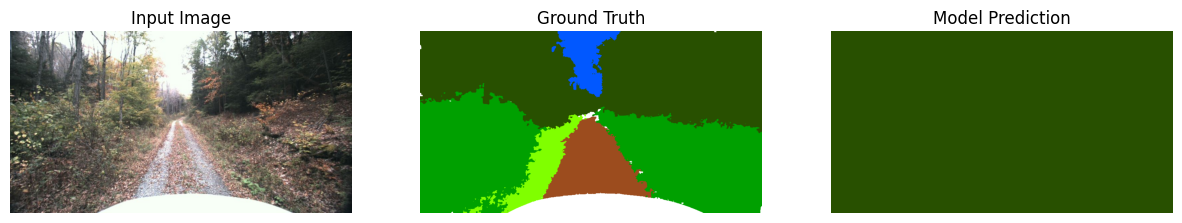

In [7]:
samples = os.listdir(test_dir)

for subdir in samples[:5]:  # first 5 samples
    subdir_path = os.path.join(test_dir, subdir)
    rgb_path = os.path.join(subdir_path, 'rgb.jpg')
    label_path = os.path.join(subdir_path, 'labels.png')
    if os.path.exists(rgb_path) and os.path.exists(label_path):
        visualize_sample_prediction(model, rgb_path, label_path, color_map, device)
